In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/beans/bespoke')

from constants import *
from traj_utils import *
import matplotlib.pyplot as plt
from viz_utils import *

In [4]:
%%time
aux, targets, run_paths = [], [], []
n_couldnt_load_runs = 0

for d in range(N_RUNNERS):
#for d in range(1):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"{BLENDER_MEMBANK_ROOT}/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets/*.npy"))
        targets_paths = [f'{run_path}/targets/{i}.npy' for i in range(1,EPISODE_LEN+1)]
        
        if n_targets_paths_files < len(targets_paths):
            print(run_path)
            n_couldnt_load_runs += 1
            continue
            
        _aux = np.concatenate([np.load(f'{run_path}/aux/{i}.npy') for i in range(1,EPISODE_LEN+1)], axis=0)
        _targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        aux.append(_aux)
        targets.append(_targets)
        run_paths.append(run_path)
        
aux = na(np.stack(aux, axis=0), AUX_PROPS)
targets = np.stack(targets, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

couldn't load 0 out of 768 runs
CPU times: user 6min 25s, sys: 1min 1s, total: 7min 26s
Wall time: 10min 38s


In [5]:
all_wp_angles, all_wp_dists, all_wp_rolls, all_wp_zs = np.split(targets, 4, axis=-1)

In [6]:
%%time
speed_mask = get_speed_mask(aux[:,:,'speed'])
all_headings = get_headings_from_traj_batch(all_wp_angles, all_wp_dists)
all_curvatures = get_curvatures_from_headings_batch(all_headings)

CPU times: user 25.7 s, sys: 0 ns, total: 25.7 s
Wall time: 25.7 s


In [7]:
aux.shape

(768, 1700, 40)

In [8]:
all_wp_angles.shape, all_wp_dists.shape, all_headings.shape, all_curvatures.shape, speed_mask.shape

((768, 1700, 30),
 (768, 1700, 30),
 (768, 1700, 30),
 (768, 1700, 30),
 (768, 1700, 30))

In [9]:
mm = 0
for i in range(len(all_curvatures)):
    m = abs(all_curvatures[i]).max()
    if m > .2:
        print(i, m)
        mm += 1

86 0.3125298


In [10]:
ix = 0
run_paths[ix]

'/media/ssd2/blender_membank/dataloader_00/run_0'

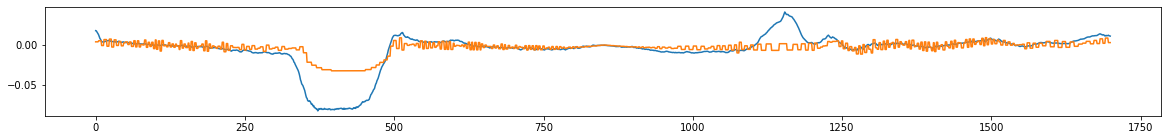

In [11]:
plt.figure(figsize=(20,2))
plt.plot(all_wp_angles[ix,:,0])
plt.plot(aux[ix,:,'curvature_at_ego'])

In [12]:
aux[ix,:,'curvature_at_ego'].max(), aux[ix,:,'curvature_at_ego'].min()

(NamedArray(0.00912828, dtype=float32), NamedArray(-0.03230043, dtype=float32))

In [13]:
import plotly.graph_objects as go
import plotly.express as px

In [15]:

y = aux[ix, :, "tire_angle"]

fig = px.scatter(x=list(range(len(y))), y=y, width=1000, height=400)

fig.add_scatter(x=list(range(len(y))), y=all_wp_angles[ix, :, 0])
fig.add_scatter(x=list(range(len(y))), y=moving_average_n(all_wp_angles[ix], 5)[:, 0])

In [16]:
# view single run

#y = all_wp_angles[ix, :, 0] 
y = aux[ix, :, "tire_angle"]

fig = px.scatter(x=list(range(len(y))), y=y, width=1000, height=400)

fig.add_scatter(x=list(range(len(y))), y=all_wp_angles[ix, :, 0])
fig.add_scatter(x=list(range(len(y))), y=all_wp_angles[ix, :, 2])
fig.add_scatter(x=list(range(len(y))), y=all_wp_angles[ix, :, 4])
fig.add_scatter(x=list(range(len(y))), y=all_wp_angles[ix, :, 6])
fig.add_scatter(x=list(range(len(y))), y=all_wp_angles[ix, :, 8])

#fig.update_xaxes(range=[0, 50])
#fig.update_yaxes(range=[0, 12])
fig.show()

In [42]:
# avg te
te = abs((aux[:, 1:, "tire_angle"] - aux[:, :-1, "tire_angle"]))
te.mean()

NamedArray(0.00070601, dtype=float32)

In [18]:
# avg te on tight curves
te[aux[:, 1:, "tire_angle"]>.2].mean()

NamedArray(0.00714177, dtype=float32)

1273515.0

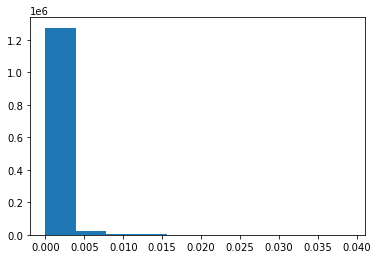

In [19]:
plt.hist(te.flatten())[0][0]

In [22]:
fig = px.scatter(x=abs(aux[::100,1:,"tire_angle"].flatten()), y=te[::100].flatten(), width=600, height=600)
fig.show()

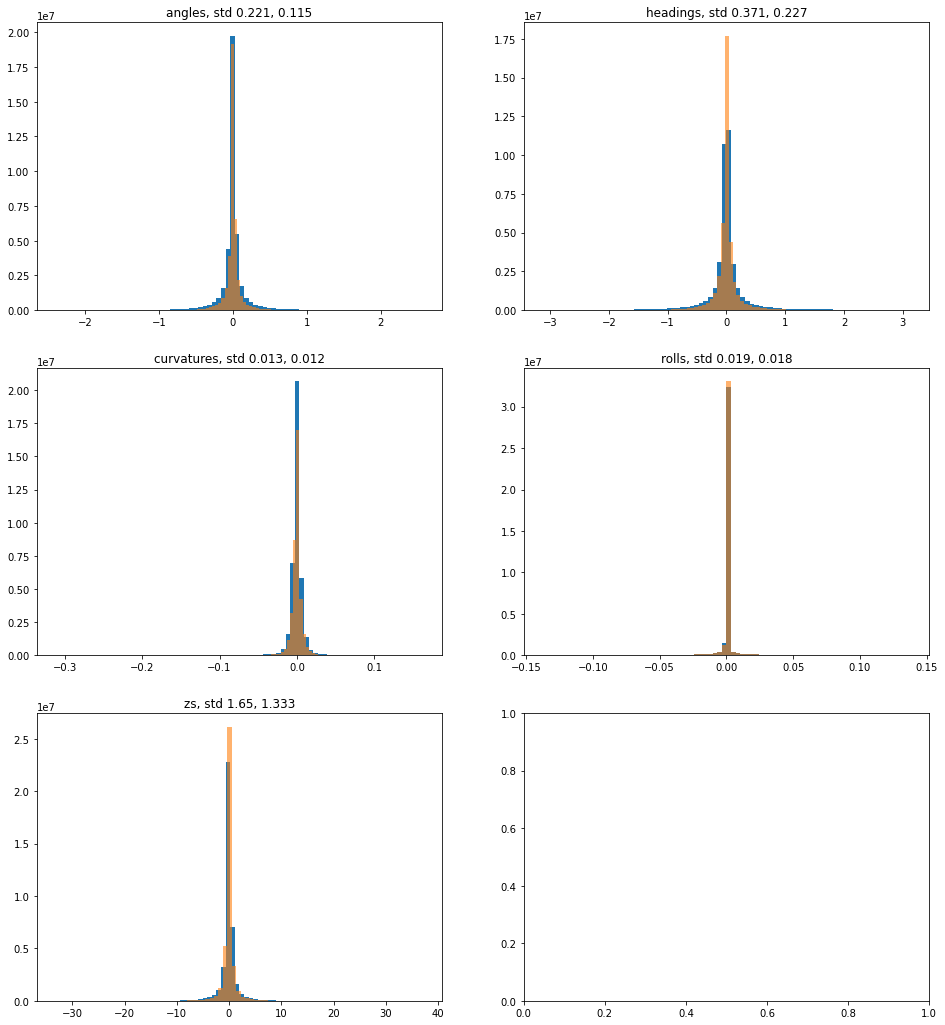

In [23]:
ws = [all_wp_angles, all_headings, all_curvatures, all_wp_rolls, all_wp_zs]
plot_wps(ws, speed_mask)

In [24]:
mean_headings = abs(all_headings).mean(axis=0).mean(0)
mean_headings

array([0.02689734, 0.03336143, 0.03957757, 0.04577192, 0.05193961,
       0.05808489, 0.06423143, 0.07039373, 0.0765949 , 0.08282439,
       0.08905336, 0.09526954, 0.10146508, 0.10763367, 0.11376814,
       0.11986054, 0.12590444, 0.1318952 , 0.13782938, 0.14353524,
       0.19728237, 0.24655053, 0.29140145, 0.33274147, 0.37078315,
       0.40546578, 0.43702397, 0.4653561 , 0.49126542, 0.5043441 ],
      dtype=float32)

In [25]:
mean_headings[-1] / mean_headings[0]

18.750702

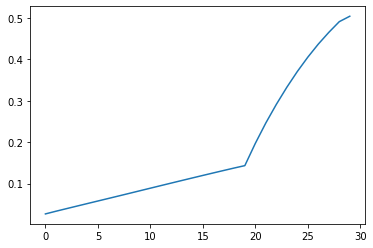

In [26]:
plt.plot(mean_headings)

In [27]:
mean_angles = abs(all_wp_angles).mean(axis=0).mean(0)
mean_angles

array([0.01555807, 0.01838657, 0.02135638, 0.02437367, 0.02740737,
       0.03044431, 0.03347892, 0.03651044, 0.03953793, 0.04256716,
       0.04560431, 0.04864703, 0.05169448, 0.05474499, 0.0577956 ,
       0.06084503, 0.06389184, 0.06693471, 0.06997205, 0.07300224,
       0.10257183, 0.13034564, 0.15623257, 0.18042457, 0.20308073,
       0.22432323, 0.24423145, 0.26286268, 0.280299  , 0.29661602],
      dtype=float32)

In [28]:
mean_angles[-1] / mean_angles[0]

19.065086

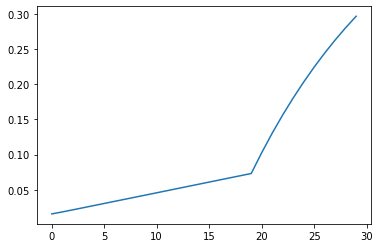

In [29]:
plt.plot(mean_angles)

In [30]:
all_wp_angles[:,:,0].std()

0.038507156

In [31]:
AUX_TARGET_PROPS

['has_stop',
 'stop_dist',
 'has_lead',
 'lead_dist',
 'lead_speed',
 'dagger_shift',
 'lane_width',
 'rd_is_lined',
 'left_turn',
 'right_turn']

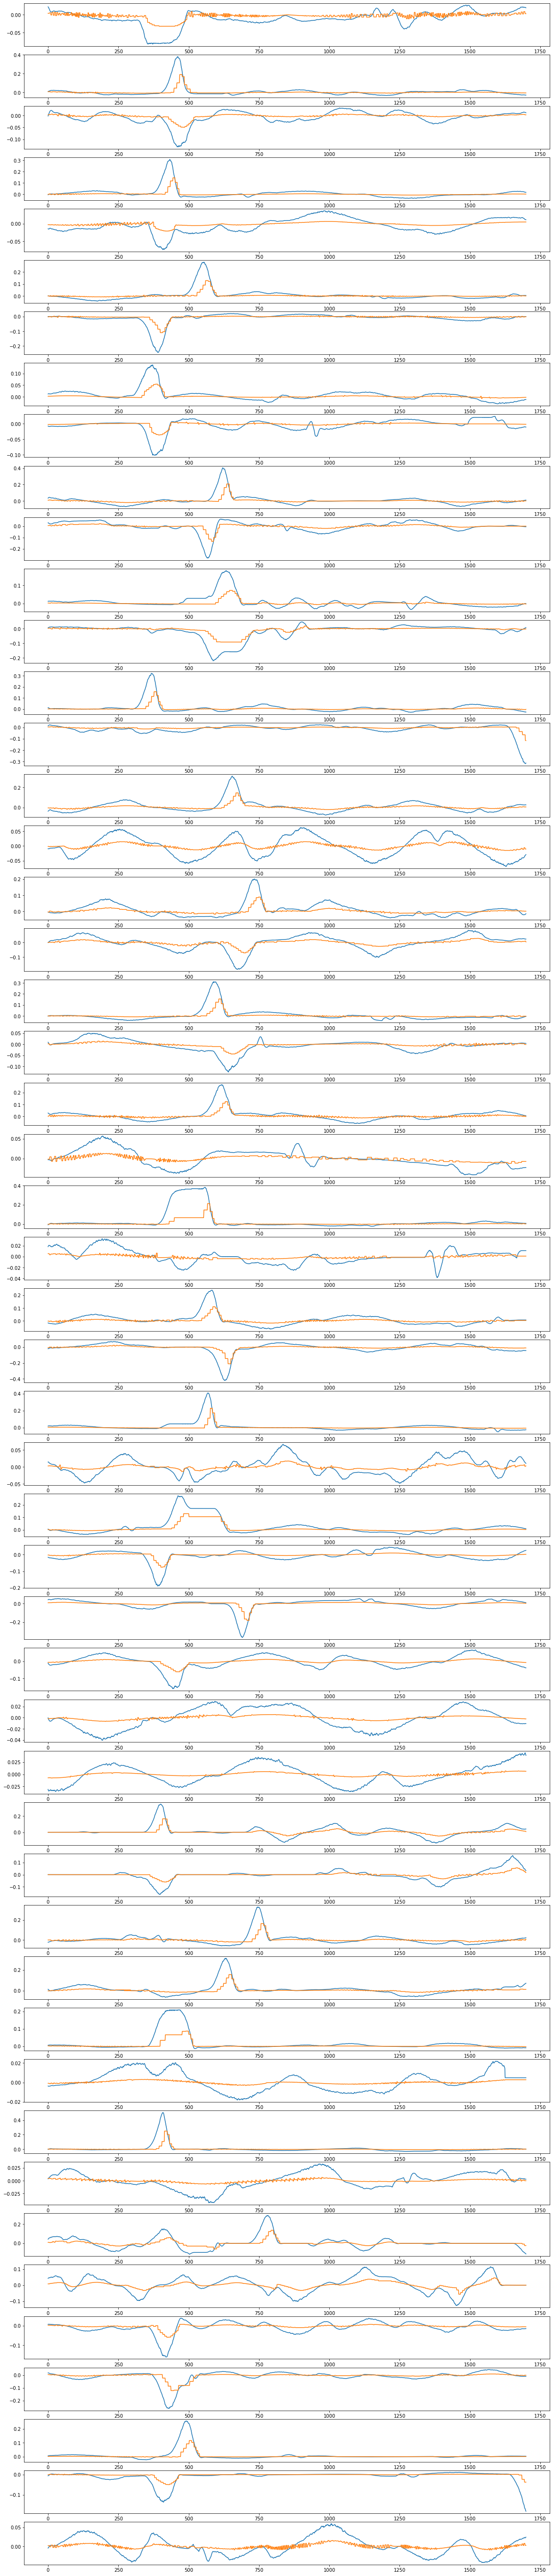

In [33]:
n_cols = 1
l = 50 # can't do all, otherwise crash
n_rows = math.ceil(l/n_cols)
fig, subplots = plt.subplots(n_rows,n_cols, figsize=(20,n_rows*2)) # figsize is w,h
subplots = subplots.flatten()

for i in range(l):
    ax = subplots[i]
    ax.plot(aux[i, :, 'tire_angle'])
    ax.plot(aux[i, :, 'curvature_at_ego'])    
    #ax.plot(aux[i, :, 'tire_angle_lagged'])
    

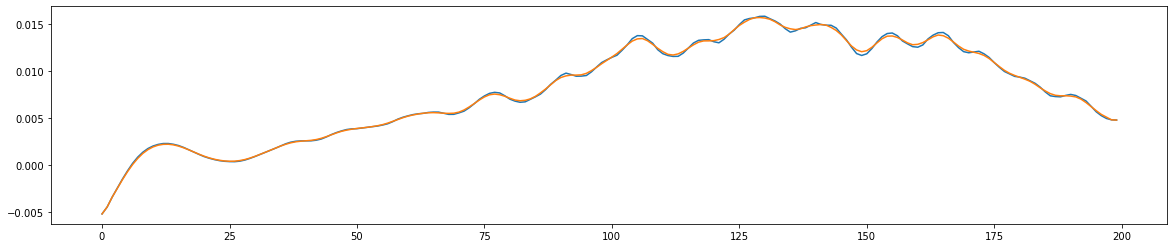

In [54]:
plt.figure(figsize=(20,4))
plt.plot(all_wp_angles[49, :200, 0])
plt.plot(moving_average(all_wp_angles[49, :200, 0], w=5))

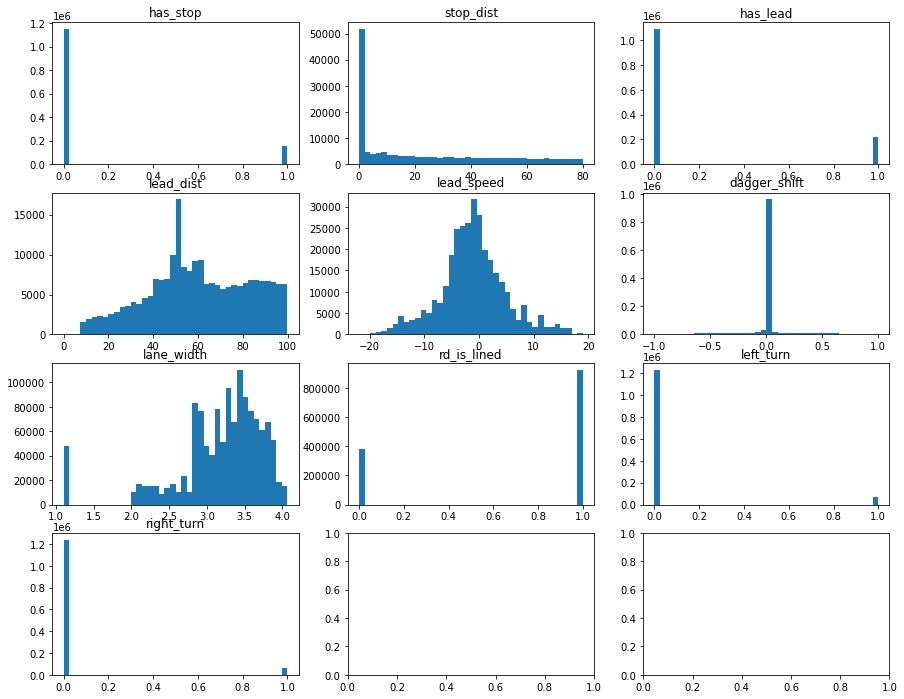

In [34]:
plot_aux(aux, AUX_TARGET_PROPS)

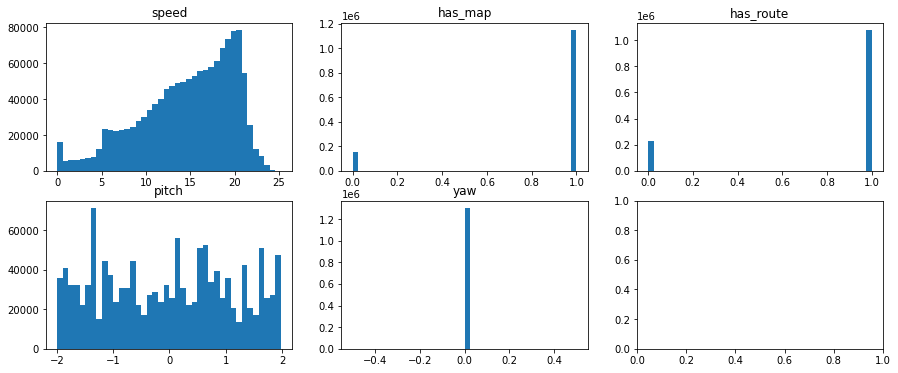

In [35]:
plot_aux(aux, AUX_MODEL_PROPS)

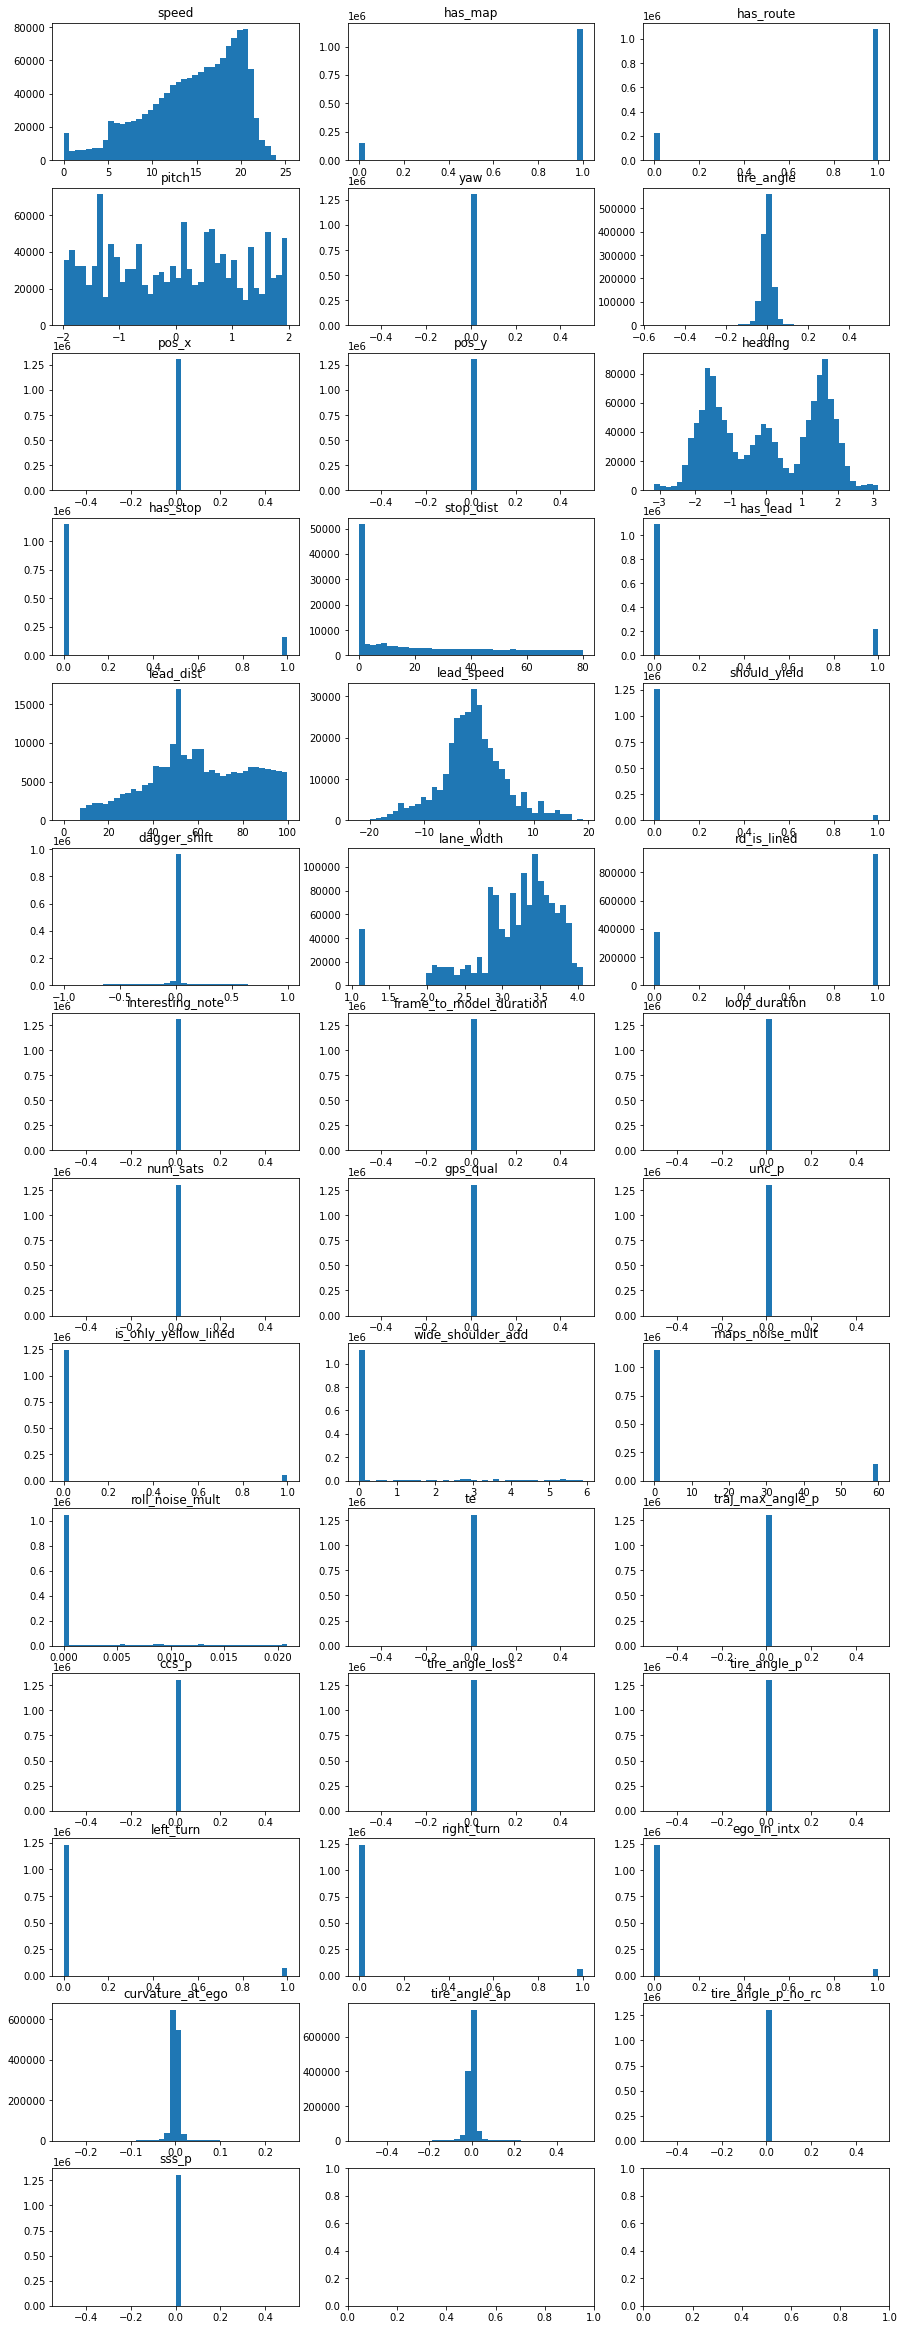

In [36]:
plot_aux(aux, AUX_PROPS)

In [37]:
np.quantile(abs(aux[:,:,"tire_angle"]), .99) #TODO this was .137, check again

0.19661881417036073

In [38]:
abs(aux[:,:,"tire_angle"]).max()

NamedArray(0.55110425, dtype=float32)

In [39]:
aux[:,:,"dagger_shift"].min()

NamedArray(-0.9997632, dtype=float32)

(array([346., 328., 201., 169.,  84., 125.,  63.,  76., 111., 197.]),
 NamedArray([0.02123775, 0.0440787 , 0.06691965, 0.08976059, 0.11260154,
             0.1354425 , 0.15828344, 0.18112439, 0.20396534, 0.22680628,
             0.24964723], dtype=float32),
 <BarContainer object of 10 artists>)

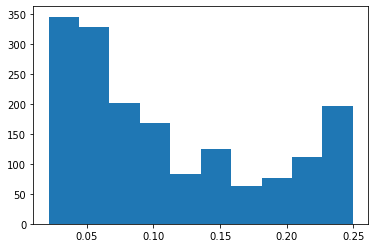

In [40]:
plt.hist(aux[:,:,"curvature_at_ego"].max(0))

In [41]:
m = aux[:,:,"curvature_at_ego"].max(0)
len(m[m<.3]) / len(m)

1.0